In [10]:
""" Import Libraries """

import numpy as np
import pandas as pd
import scipy as sp
import scipy.integrate
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import os

os.getcwd()

'C:\\Users\\moche\\Documents\\working_programs'

In [3]:
" Utility Functions"

def namestr(obj, namespace):
    """
    Calls name of non string variable as a string
    
    Inputs: 'obj'       - Any non string object to be named
            'namespace' - Symbol table to be accessed
    
    Outputs: variable as string
    
    """
    
    return [name for name in namespace if namespace[name] is obj]

In [6]:
" Import data from .csv into a numpy array and perform PCA "

# Make data array 
df = pd.read_csv('Lip_space_time-17-Nov-2021.csv')
data = df.to_numpy()

# Remove NaN columns 
adj_data = np.delete(data,[7,12,13,14],1) # Removed PI45P2, Carmil, ArpB & PI4P columns 


In [7]:
" PCA Cell "

def standardize_data(arr):
    
    '''
    This function standardizes an array by substracting each element by 
    the column mean value and then dividing the standard deviation.
    
    Inputs: arr(array) 
    Outputs: standardizedArray(array)
    '''    
    rows, columns = arr.shape
    
    standardizedArray = np.zeros(shape=(rows, columns))
    tempArray = np.zeros(rows)
    
    for column in range(columns):
        
        mean = np.mean(arr[:,column])
        std = np.std(arr[:,column])
        tempArray = np.empty(0)
        
        for element in arr[:,column]:
            
            tempArray = np.append(tempArray, ((element - mean) / std))
 
        standardizedArray[:,column] = tempArray
    
    return standardizedArray

cov_mat = np.cov(standardize_data(adj_data), rowvar=False)

eigen_values, eigen_vectors = np.linalg.eig(cov_mat)
#print("Eigenvector: \n",eigen_vectors,"\n")
#print("Eigenvalues: \n", eigen_values, "\n")

#plt.style.use('ggplot')
#plt.title("Eigenvalue against Principal Component Number")
#print(eigen_vectors)
#plt.plot(eigen_values)

In [8]:
" Data Processing "

def dc_dt(c_arr, t_int, mov_len):
    
    """
    - Function to calculate the corresponding rate of change of flux w.r.t time.
    - Under assumption that input c_arr follows time scheme given in df of input data.
    - First 19 values are calculated with constant time interval 3s, 20th automatically
      set to zero. 
    
    Inputs: c_arr(array(1D))   - Input array of concentration values for series of cup closures 
            t_int(int)         - Time interval at which measurements were taken for concentration values
            mov_len(int)       - How many time intervals (t_int) per movie
   
    Outputs: dc_arr(array(1D)) - Output array of dc/dt values for all concentration points sans 20*nth values
    
    """
    
    num_of_elements = len(c_arr) 
    num_of_movies = num_of_elements/mov_len
    
    zero_ind_arr = np.subtract(np.multiply(np.arange(1,num_of_movies+1),mov_len),1)
    dc_arr = np.empty([num_of_elements,1])
    
    for value in range(num_of_elements-1):
        
        dc_arr[value]= (c_arr[value+1]-c_arr[value])/t_int
    
    for index in range(len(zero_ind_arr)):
        
        dc_arr[int(zero_ind_arr[index])] = 0
    
    return dc_arr

#print(dc_dt(adj_data[:,3],3,20))




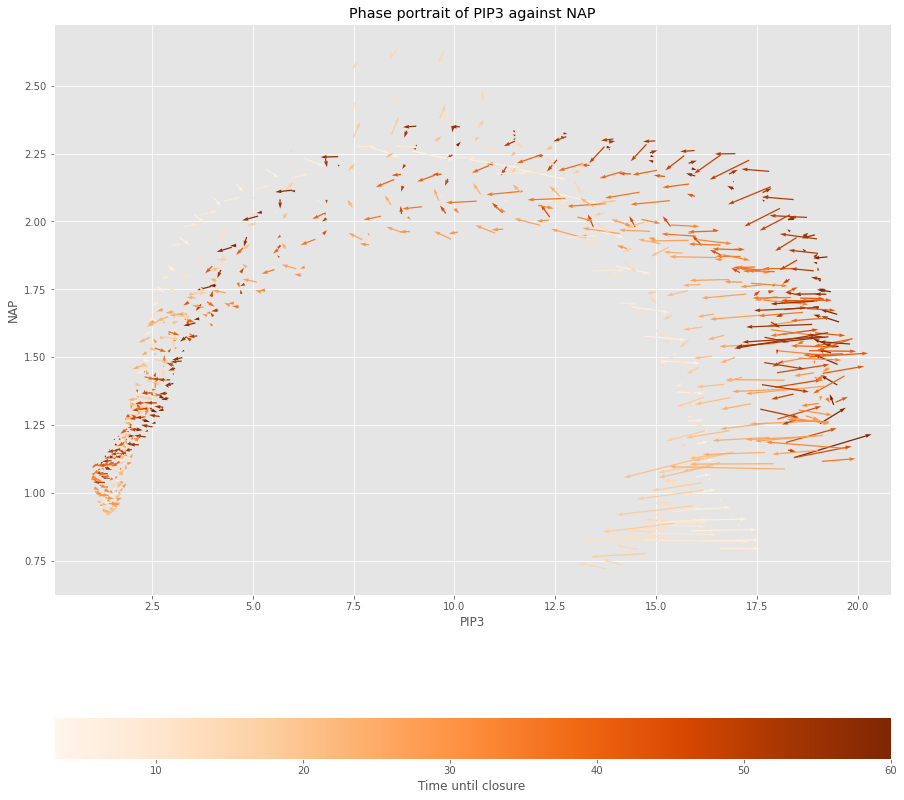

In [23]:
" Phase portrait graphics processing "

# Extract column values separately 
gDistance = adj_data[:,0]
time = adj_data[:,1]
Curvature = adj_data[:,2]
PIP3 = adj_data[:,3]
Actin= adj_data[:,4]
NAP = adj_data[:,5]
PI34P2 = adj_data[:,6]
PTEN = adj_data[:,7]
Myo1B = adj_data[:,8]
Myo1E = adj_data[:,9]
Coronin = adj_data[:,10]

# initialise 2 component system
a = PIP3
h = NAP
dadt = dc_dt(a,3,20)
dhdt = dc_dt(h,3,20)

str_a = namestr(a, globals())[0]
str_h = namestr(h, globals())[0]

# define colour map
colour = np.multiply(time,-1) # make positive to normalise as [0,1]
norm = Normalize() # Norm func
norm.autoscale(colour) # Scale 'colour' array elements between 0 and 1 
colourmap = cm.Oranges # RGB mapping to be used

# create a scalar mappable
sm = plt.cm.ScalarMappable(cmap=colourmap, norm=norm)
sm.set_array([])

fig, ax = plt.subplots()
ax.quiver(a, h, dadt,dhdt,scale=5,width=0.0015, color=colourmap(norm(colour)))
plt.colorbar(sm, label='Time until closure', orientation='horizontal')
fig.set_figwidth(15)
fig.set_figheight(15)
plt.title("Phase portrait of " + str_a + " against " + str_h)
plt.xlabel(str_a)
plt.ylabel(str_h)
plt.style.use('ggplot')
#plt.savefig(str_a+"_"+str_h,dpi=300)

Text(0, 0.5, 'w')

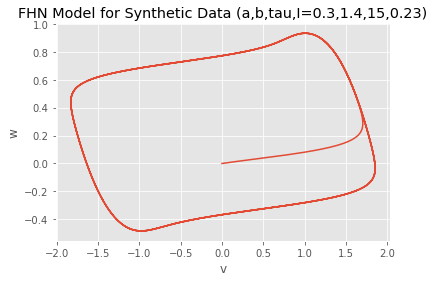

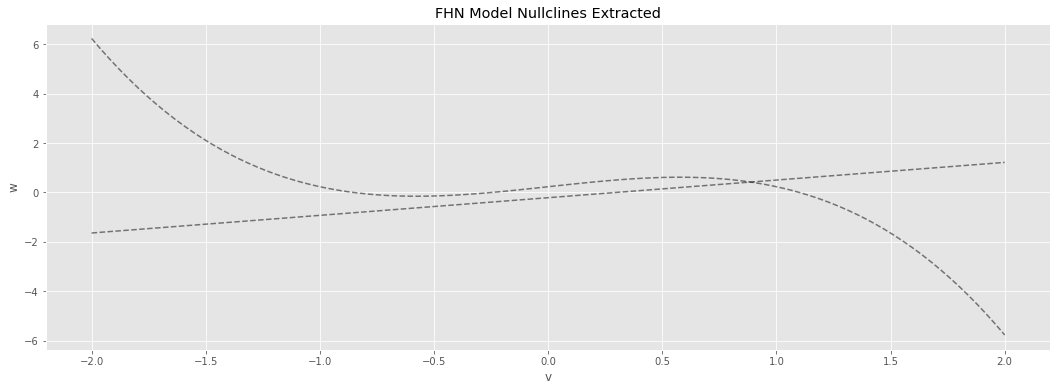

In [43]:
" Fitzhugh Nagumo Model "

# Set up initial conditions
p = (0.3,1.4,15,0.23) #a,b,tau,I
time_span = np.linspace(3, 60, num=1500)

scenarios = [
     {"a":-.3, "b":1.4, "tau":20, "I":0},
     {"a":-.3, "b":1.4, "tau":20, "I":0.23},
     {"a":-.3, "b":1.4, "tau":20, "I":0.5}
]
time_span = np.linspace(0, 200, num=1500)

# Define model to solve
def fhn_model(x, t, a, b, tau, I):
    """
    Inputs: 'x' (array) - [membrane potential, recovery variable]
            't' (float) - time
            'a' (float) - parameter 1
            'b' (float) - parameter 2
            'tau' (float) - timescale
            'I' (float) - Stimulus constant
    Outputs: dx/dt (array) - time derivative of x[0] and x[1]
    """
    dx0dt = x[0] - (x[0]**3/3) - x[1] + I # dv/dt
    dx1dt = (x[0] + a - b*x[1])/tau # dw/dt
    
    return np.array([dx0dt, dx1dt])

# Solve that model 

result_int = scipy.integrate.odeint(fhn_model, t=time_span,y0=[0,0], args= p)
plt.title("FHN Model for Synthetic Data (a,b,tau,I=0.3,1.4,15,0.23)")
plt.xlabel("v")
plt.ylabel("w")
plt.plot(result_int[:,0], result_int[:,1])

# Solve for nullclines where dx/dt = 0

def plot_nullcline(ax, a, b, tau, I, color='k', style='--', opacity=.5, vmin=-2,vmax=2):
    """Plot the null iscolines of the Fitzhugh nagumo system"""
    v = np.linspace(vmin,vmax,100)
    ax.plot(v, v - v**3 + I, style, color=color, alpha=opacity)
    ax.plot(v, (v - a)/b, style, color=color, alpha=opacity)

fig, ax = plt.subplots(1, 1, figsize=(18, 6))
plot_nullcline(ax,0.3,1.4,15,0.23)
plt.title("FHN Model Nullclines Extracted")
plt.xlabel("v")
plt.ylabel("w")